[<img src="photutils_banner.svg" width=300>](http://photutils.readthedocs.io/en/stable/index.html)

# Source Detection with `photutils`
---

##### What is source detection?
In order to do photometry on astronomical image data, one must first determine the locations of the sources in the image. Source detection methods find sources algorithmically, by looking for regions of an image where the signal from a source is statistically higher than the signal from background noise. Some algorithms search for sources whose profiles match specific data models, such as a 2-D Gaussian, while others simply look for local maxima.

The `photutils` package provides a variety of tools that use different detection algorithms to locate sources in an image.

##### What does this tutorial include?
This tutorial covers different tools for source detection with `photutils`, including the following methods:
* Source Detection with `DAOStarFinder`
* Source Detection with `IRAFStarFinder`
* Source Detection with `find_peaks`
* Image Segmentation

The methods demonstrated here are available in narrative form within the `photutils.detection` [documentation](http://photutils.readthedocs.io/en/stable/detection.html) and `photutils.segmentation` [documentation](http://photutils.readthedocs.io/en/stable/segmentation.html).

<div class="alert alert-block alert-warning">**Important:** Before proceeding, please be sure to update your versions of `astropy`, `matplotlib`, and `photutils`, or this notebook may not work properly. Or, if you don't want to handle packages individually, you can always use (and keep updated!) the [AstroConda](https://astroconda.readthedocs.io) distribution.</div>

---

## Import necessary packages

First, let's import packages that we will use to perform arithmetic functions and visualize data:

In [1]:
import numpy as np

from astropy.io import fits
import astropy.units as u
from astropy.nddata import CCDData
from astropy.stats import sigma_clipped_stats, SigmaClip
from astropy.visualization import ImageNormalize, LogStretch

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.ticker import LogLocator

from photutils.background import Background2D, MeanBackground

# Show plots in the notebook
% matplotlib inline

Let's also define some `matplotlib` parameters, such as title font size and the dpi, to make sure our plots look nice. To make it quick, we'll do this by loading a [prewritten style file](photutils_notebook_style.mplstyle) into `pyplot`. (See [here](https://matplotlib.org/users/customizing.html) to learn more about customizing `matplotlib`.)

In [2]:
plt.style.use('photutils_notebook_style.mplstyle')

## Retrieve data

For this example, we will be using Hubble eXtreme Deep Field (XDF) data, collecting using the Advanced Camera for Surveys (ACS) on Hubble between 2002 and 2012 and totalling 1.8 million seconds (500 hours!) of exposure time.

Since this file is too large to store on GitHub, we will just use astropy to directly download the file from the STScI archive: https://archive.stsci.edu/prepds/xdf/

In [3]:
url = 'https://archive.stsci.edu/pub/hlsp/xdf/hlsp_xdf_hst_acswfc-60mas_hudf_f435w_v1_sci.fits'
with fits.open(url) as hdulist:
    hdulist.info()
    data = hdulist[0].data
    header = hdulist[0].header

Filename: /Users/lchambers/.astropy/cache/download/py3/0e8dfa87b3e49367d836de86e28a40ec
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      34   (5250, 5250)   float32   


As explained in the [previous notebook](01_photutils_background_estimation.ipynb) on background estimation, it is important to mask these data, as a large portion of the values are equal to zero. We will **mask** out the non-data, so all of those pixels that have a value of zero don't interfere with our statistics and analyses of the data. 

In [4]:
# Define the mask
mask = data == 0

Throughout this notebook, we are going to store our images in Python using a `CCDData` object (see [Astropy documentation](http://docs.astropy.org/en/stable/nddata/index.html#ccddata-class-for-images)), which contains a `numpy` array in addition to metadata such as uncertainty, masks, or units. In this case, our data is in electrons (counts) per second.

In [6]:
unit = u.ct / u.s
xdf_image = CCDData(data, unit=unit, meta=header, mask=mask)

Let's look at the data:

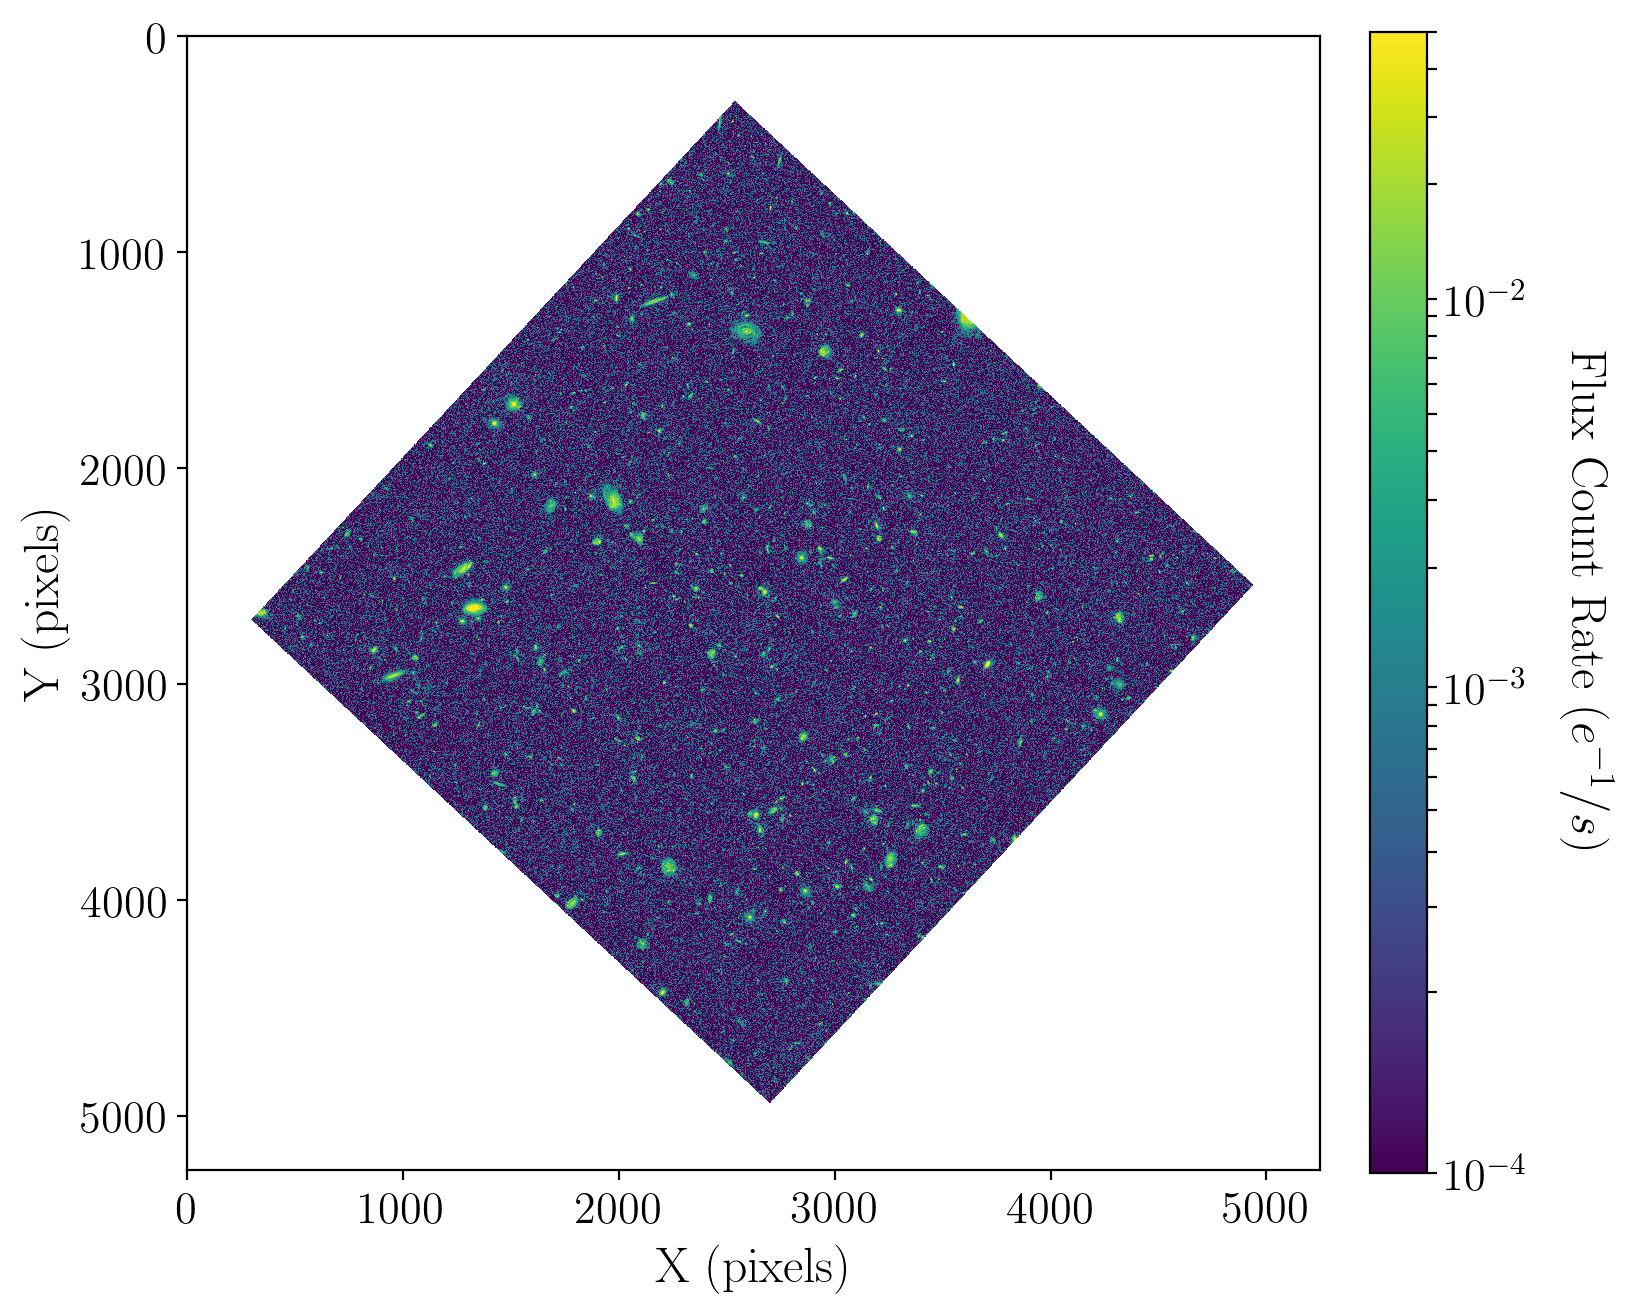

In [7]:
# Set up the figure with subplots
fig, ax1 = plt.subplots(1, 1, figsize=(8, 8))

# Plot the data
norm_image = ImageNormalize(vmin=1e-4, vmax=5e-2, stretch=LogStretch())
xdf_image_clipped = np.clip(xdf_image, 1e-4, None) # clip to plot with logarithmic stretch
fitsplot = ax1.imshow(np.ma.masked_where(xdf_image.mask, xdf_image_clipped), norm=norm_image)

# Define the colorbar and fix the labels
cbar = plt.colorbar(fitsplot, fraction=0.046, pad=0.04, ticks=LogLocator(subs=range(10)))
labels = ['$10^{-4}$'] + [''] * 8 + ['$10^{-3}$'] + [''] * 8 + ['$10^{-2}$']
cbar.ax.set_yticklabels(labels)

# Define labels
cbar.set_label(r'Flux Count Rate ($e^{-1}/s$)', rotation=270, labelpad=30)
ax1.set_xlabel('X (pixels)')
ax1.set_ylabel('Y (pixels)')

plt.show()

---
## Source Detection with `DAOStarFinder`

With the `DAOStarFinder` [class](http://photutils.readthedocs.io/en/stable/api/photutils.DAOStarFinder.html), `photutils` provides users with an easy application of the popular [DAOFIND](http://stsdas.stsci.edu/cgi-bin/gethelp.cgi?daofind) algorithm ([Stetson 1987, PASP 99, 191](http://adsabs.harvard.edu/abs/1987PASP...99..191S)), originally developed at the Dominion Astrophysical Observatory. 

This algorithm detects sources by:
* Searching for local maxima
* Selecting only sources with peak amplitude above a defined threshold
* Selecting sources with sizes and shapes that match a 2-D Gaussian kernel (circular or elliptical)

It returns:
* Location of the source centroid
* Parameters reflecting the source's sharpness and roundness

Generally, the threshold that source detection algorithms use is defined as a multiple of the standard deviation. So first, we need to calculate statistics for the data:

In [11]:
mean, median, std = sigma_clipped_stats(xdf_image.data, sigma=3.0, iters=5, mask=xdf_image.mask)

Now, let's run the `DAOStarFinder` algorithm on our data and see what it finds. 

In [22]:
from photutils import DAOStarFinder

In [23]:
daofind = DAOStarFinder(fwhm=5.0, threshold=20.*std)
sources_dao = daofind(xdf_image * ~xdf_image.mask)    
print(sources_dao)

 id    xcentroid     ycentroid   ...      flux           mag       
---- ------------- ------------- ... ------------- ----------------
   1  2466.8549733   383.4400466 ... 1.02844155818  -0.030449044208
   2   2509.738329 389.514188831 ... 1.56210023552  -0.484272244686
   3 2465.51286522 393.357597326 ... 1.92492172215  -0.711032683532
   4 2525.25521353 393.544062284 ... 11.3241380224   -2.63501288513
   5 2465.22039167 412.428367365 ... 1.11740224029  -0.120523844367
   6 2551.71611445 458.628164677 ... 1.28791443878  -0.274717530234
   7 2613.70435017 463.580036724 ...  1.8605865627  -0.674124700312
   8 2677.99125845 496.090175963 ... 2.10858320935   -0.80997685977
   9  2585.5858743 507.273456713 ... 3.53261587779   -1.37024104149
  10 2325.64476932  553.77336051 ... 1.51360065866  -0.450028270112
 ...           ...           ... ...           ...              ...
1457 2955.91465782 4662.61060561 ... 1.40803661252  -0.371534869275
1458 2814.06917215 4663.41295507 ... 1.453884822

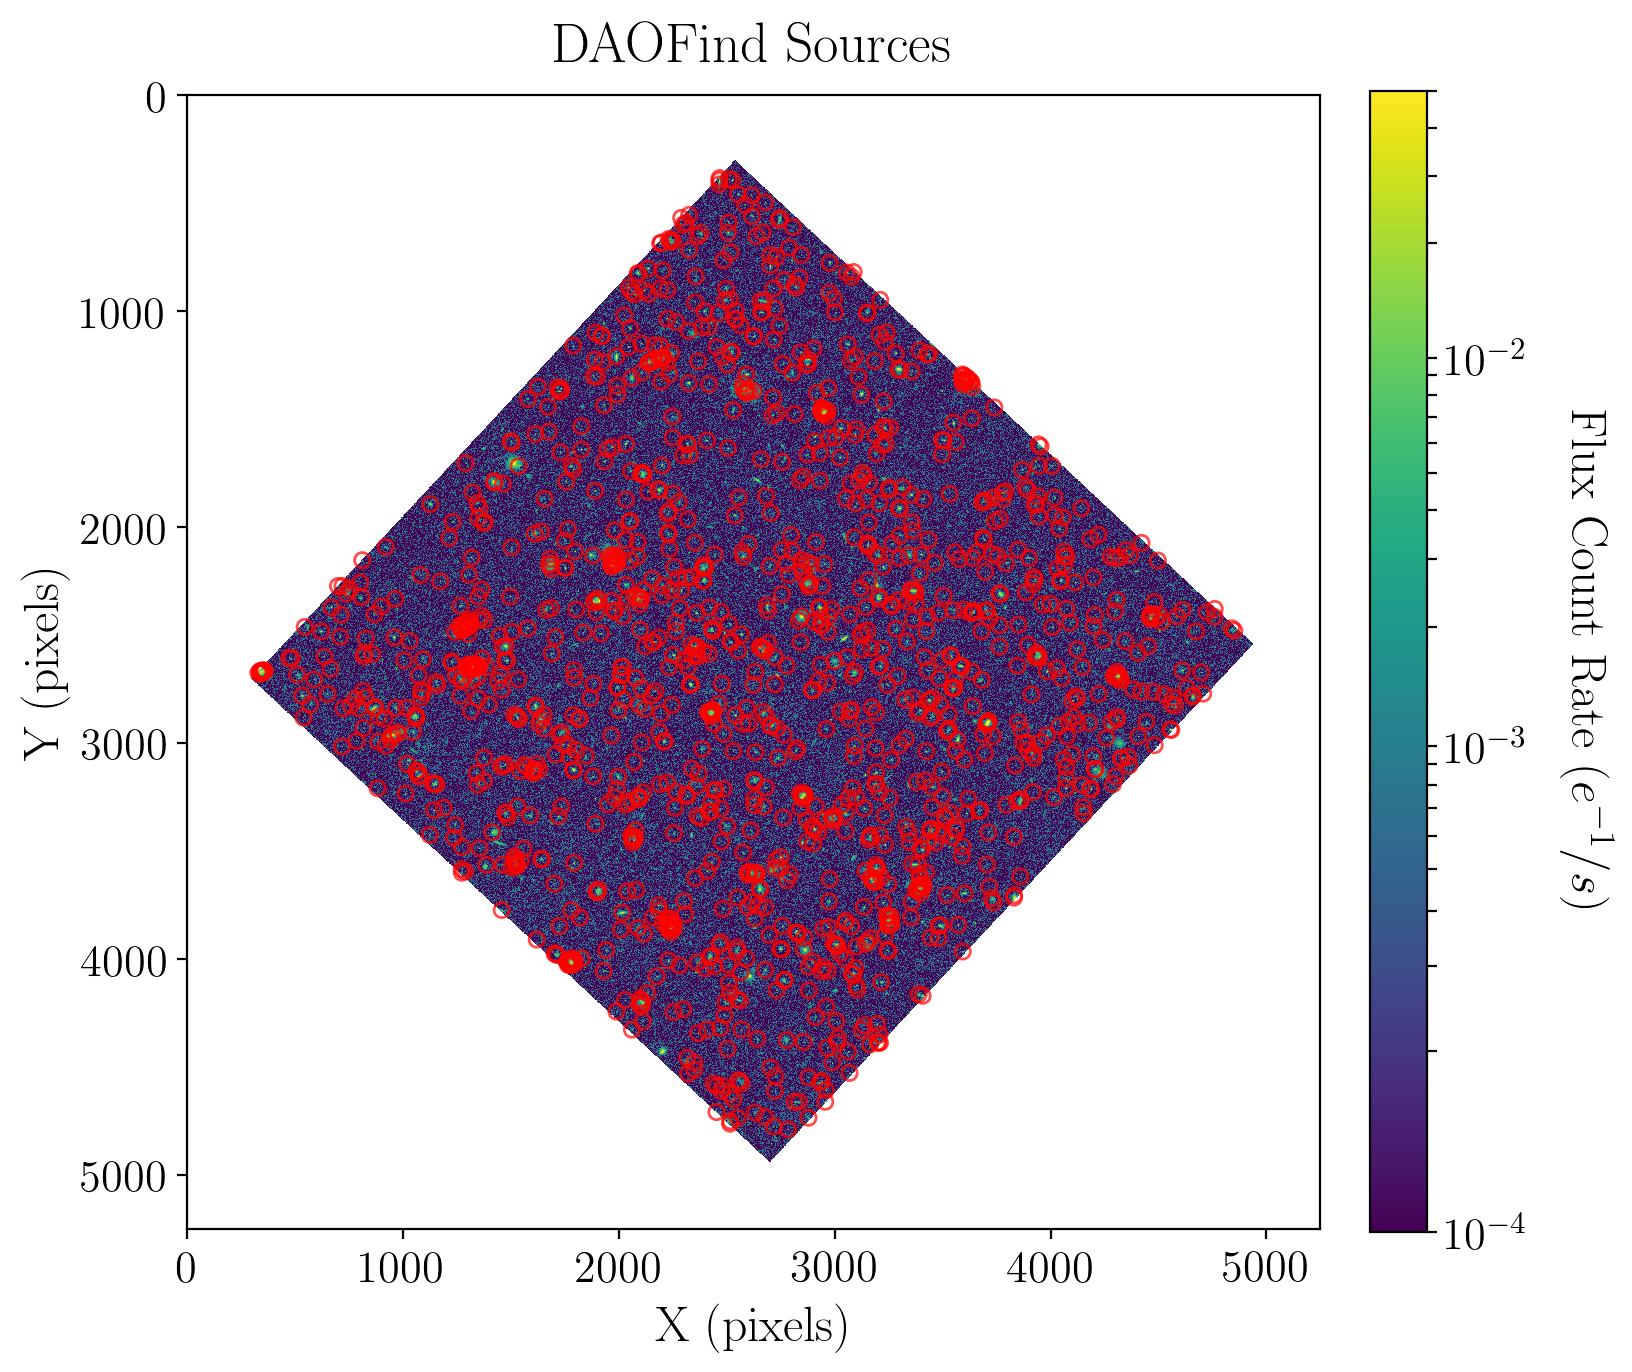

In [24]:
# Set up the figure with subplots
fig, ax1 = plt.subplots(1, 1, figsize=(8, 8))

# Plot the data
fitsplot = ax1.imshow(np.ma.masked_where(xdf_image.mask, xdf_image_clipped), norm=norm_image)
ax1.scatter(sources_dao['xcentroid'], sources_dao['ycentroid'], s=30, marker='o', 
            lw=1, alpha=0.7, facecolor='None', edgecolor='r')

# Define the colorbar and fix the labels
cbar = plt.colorbar(fitsplot, fraction=0.046, pad=0.04, ticks=LogLocator(subs=range(10)))
labels = ['$10^{-4}$'] + [''] * 8 + ['$10^{-3}$'] + [''] * 8 + ['$10^{-2}$']
cbar.ax.set_yticklabels(labels)

# Define labels
cbar.set_label(r'Flux Count Rate ($e^{-1}/s$)', rotation=270, labelpad=30)
ax1.set_xlabel('X (pixels)')
ax1.set_ylabel('Y (pixels)')
ax1.set_title('DAOFind Sources')

plt.show()

<div class="alert alert-block alert-info">
<h3>**Exercises:**</h3><br>
Re-run the `DAOStarFinder` algorithm with a smaller threshold (like 5&sigma;), and plot the sources that it finds. Do the same, but with a larger threshold (like 100&sigma;). How did changing the threshold affect the results?
</div>

## Source Detection with `IRAFStarFinder`

Similarly to `DAOStarFinder`, `IRAFStarFinder` is a class that implements a pre-existing algorithm that is widely used within the astronomical community. This class uses the `starfind` [algorithm](http://stsdas.stsci.edu/cgi-bin/gethelp.cgi?starfind)  that was originally part of IRAF.

`IRAFStarFinder` is fundamentally similar to `DAOStarFinder` in that it detects sources by finding local maxima above a certain threshold that match a Gaussian kernel. However, `IRAFStarFinder` differs in the following ways:
* Does not allow users to specify an elliptical Gaussian kernel
* Uses image moments to calculate the centroids, roundness, and sharpness of objects

Let's run the `IRAFStarFinder` algorithm on our data, with the same FWHM and threshold, and see how its results differ from `DAOStarFinder`:

In [25]:
from photutils import IRAFStarFinder

In [27]:
iraffind = IRAFStarFinder(fwhm=5.0, threshold=20.*std)
sources_iraf = iraffind(xdf_image * ~xdf_image.mask)    
print(sources_iraf)

 id   xcentroid     ycentroid   ...      flux            mag      
--- ------------- ------------- ... -------------- ---------------
  1 2509.71903339 389.604714863 ... 0.145116519644    2.0957078648
  2 2613.69411358 463.610285714 ... 0.193817611388   1.78151690746
  3 2635.00022551 470.896270869 ... 0.109746240229   2.39902587307
  4 2585.63515093 507.289853176 ... 0.290729891842   1.34127578319
  5 2297.13103197 600.106635564 ... 0.167608127217   1.93926231629
  6 2806.39192279 610.156476428 ... 0.120267381596   2.29963036045
  7 2506.10412758  636.82379476 ... 0.289753053321   1.34492994723
  8 2326.40767932 717.132722293 ...  0.22564121472   1.61645392739
  9  2516.9536964 727.302446135 ...  0.12704250262   2.24012739908
 10 2702.49277269 740.917164061 ... 0.113582379819   2.36172259015
...           ...           ... ...            ...             ...
201 1701.96127001 3975.70683057 ... 0.373259332494   1.06997331232
202 2677.40754757 4051.00679897 ...  1.14232972884 -0.14447869

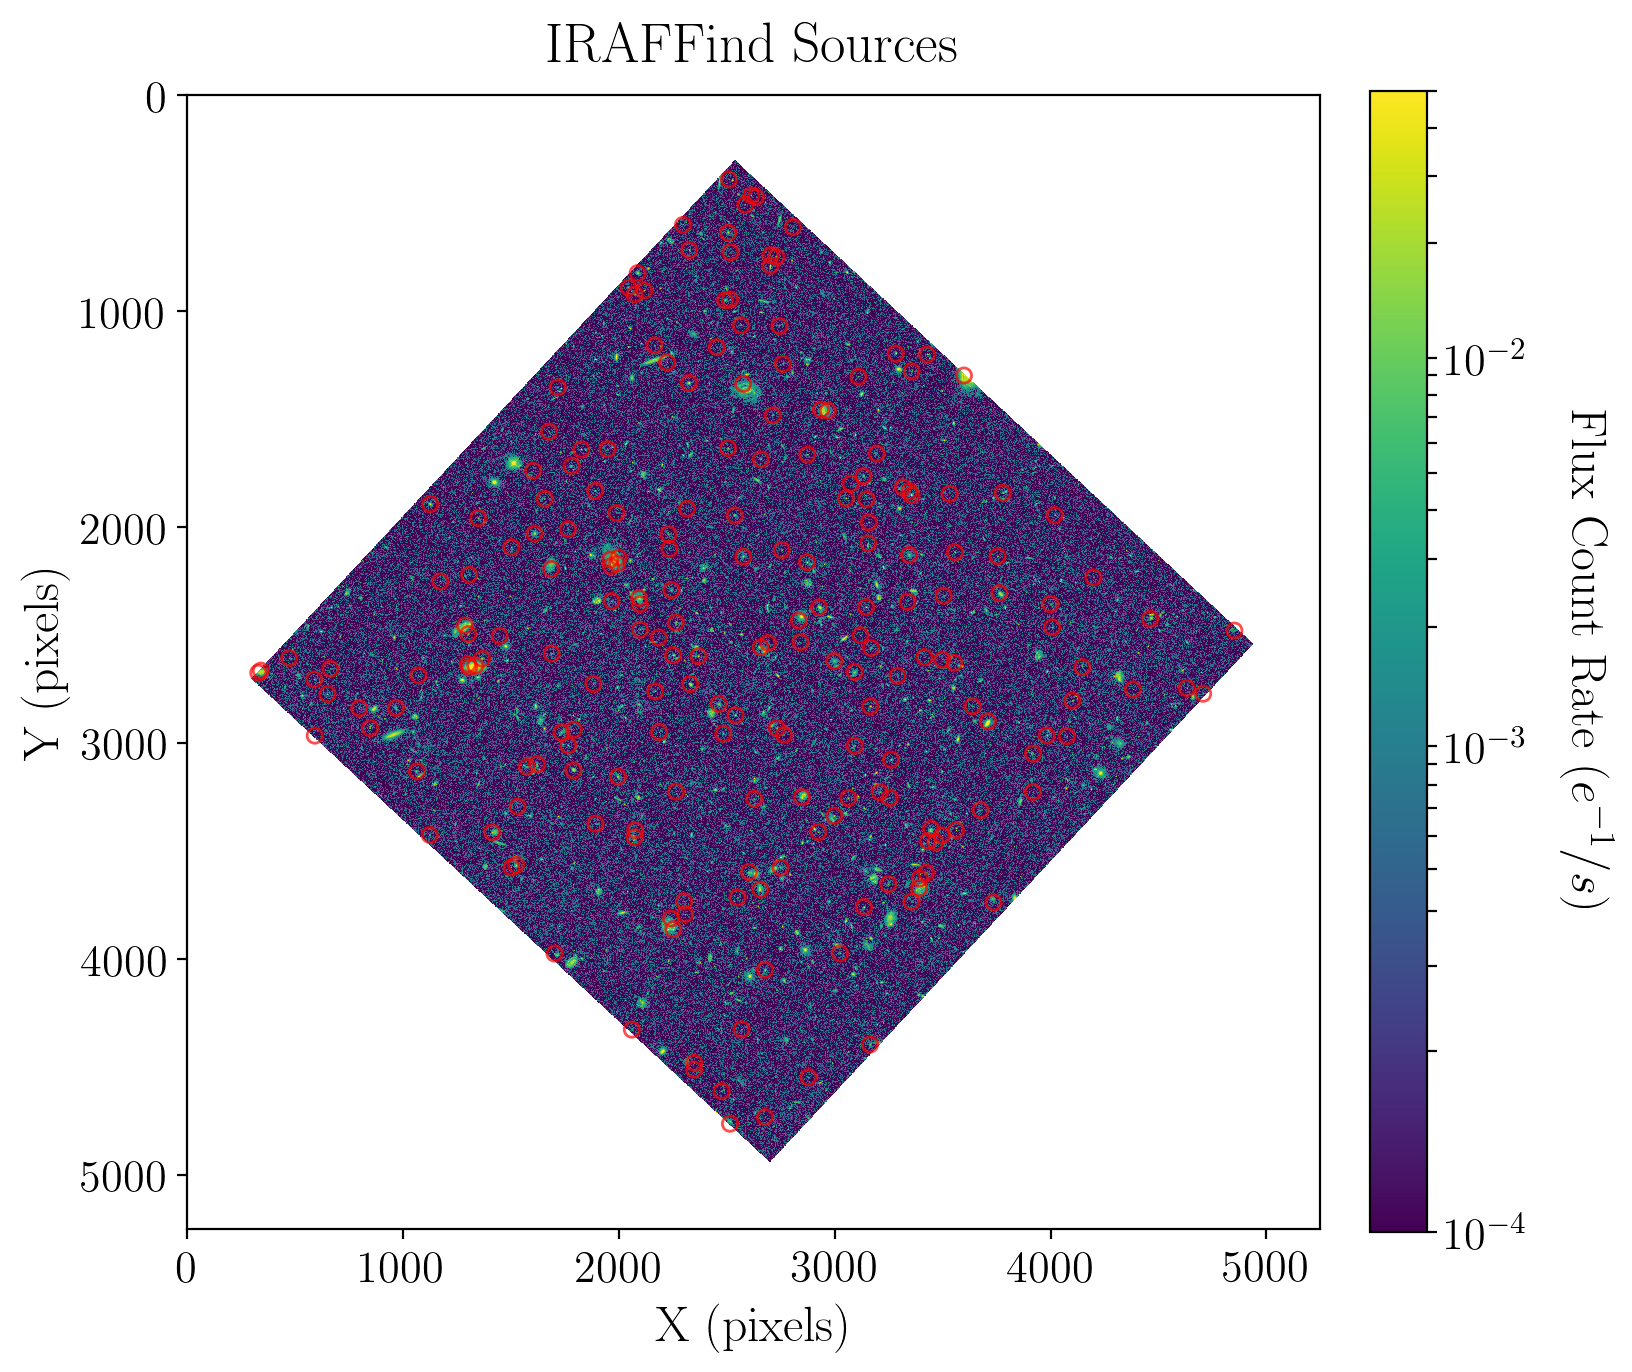

In [28]:
# Set up the figure with subplots
fig, ax1 = plt.subplots(1, 1, figsize=(8, 8))

# Plot the data
fitsplot = ax1.imshow(np.ma.masked_where(xdf_image.mask, xdf_image_clipped), norm=norm_image)
ax1.scatter(sources_iraf['xcentroid'], sources_iraf['ycentroid'], s=30, marker='o', 
            lw=1, alpha=0.7, facecolor='None', edgecolor='r')

# Define the colorbar and fix the labels
cbar = plt.colorbar(fitsplot, fraction=0.046, pad=0.04, ticks=LogLocator(subs=range(10)))
labels = ['$10^{-4}$'] + [''] * 8 + ['$10^{-3}$'] + [''] * 8 + ['$10^{-2}$']
cbar.ax.set_yticklabels(labels)

# Define labels
cbar.set_label(r'Flux Count Rate ($e^{-1}/s$)', rotation=270, labelpad=30)
ax1.set_xlabel('X (pixels)')
ax1.set_ylabel('Y (pixels)')
ax1.set_title('IRAFFind Sources')

plt.show()

The `IRAFStarFinder` algorithm only found 211 sources in our data - 14% of what `DAOStarFinder` found. This is perhaps because the `IRAFStarFinder` kernel is restricted to a circular 2D Gaussian kernel, and the more elliptical objects were not identified as sources.

## Source Detection with `find_peaks`

For more general source detection cases that do not require rigorous comparison with models, `photutils` offers the `find_peaks` function. 

This function simply finds sources by identifying local maxima above a given threshold and separated by a given distance, rather than trying to fit data to a given model. Unlike the previous detection algorithms, `find_peaks` does not necessarily calculate objects' centroids. Unless the `subpixel` argument is set to `True`, `find_peaks` will return just the integer value of the peak pixel for each source.

This algorithm is particularly useful for identifying non-stellar sources or heavily distorted sources in image data.

Let's see how it does:

In [32]:
from photutils import find_peaks

In [35]:
sources_findpeaks = find_peaks(xdf_image.data, mask=xdf_image.mask, 
                               threshold=20.*std, box_size=30, subpixel=True)    
print(sources_findpeaks)

x_peak y_peak    peak_value     x_centroid    y_centroid   fit_peak_value 
------ ------ --------------- ------------- ------------- ----------------
  2525    393  0.135451431669 2525.26336344 393.522873509   0.148650154217
  2466    400 0.0293336217897 2465.79286017 398.043364628  0.0176606822995
  2552    459 0.0182768105637 2552.27027749 458.677562683  0.0128598945238
  2614    463 0.0181947905506 2613.69613343 463.585076076  0.0188133711757
  2635    471   0.02110125573 2634.95133293 470.852386839  0.0202602906652
  2635    493 0.0802389496746 2634.69820691  492.74148748  0.0884658508479
  2678    496 0.0263793695322 2678.00665363 496.104221038  0.0231172450607
  2586    507 0.0371396664944 2585.55584526 507.289268428  0.0407944364417
  2326    554 0.0180919227549 2325.61909864 553.721724536  0.0163059002803
  2616    560 0.0214566899806 2615.88885262 559.974613217  0.0184869253028
   ...    ...             ...           ...           ...              ...
  2531   4651 0.017485019

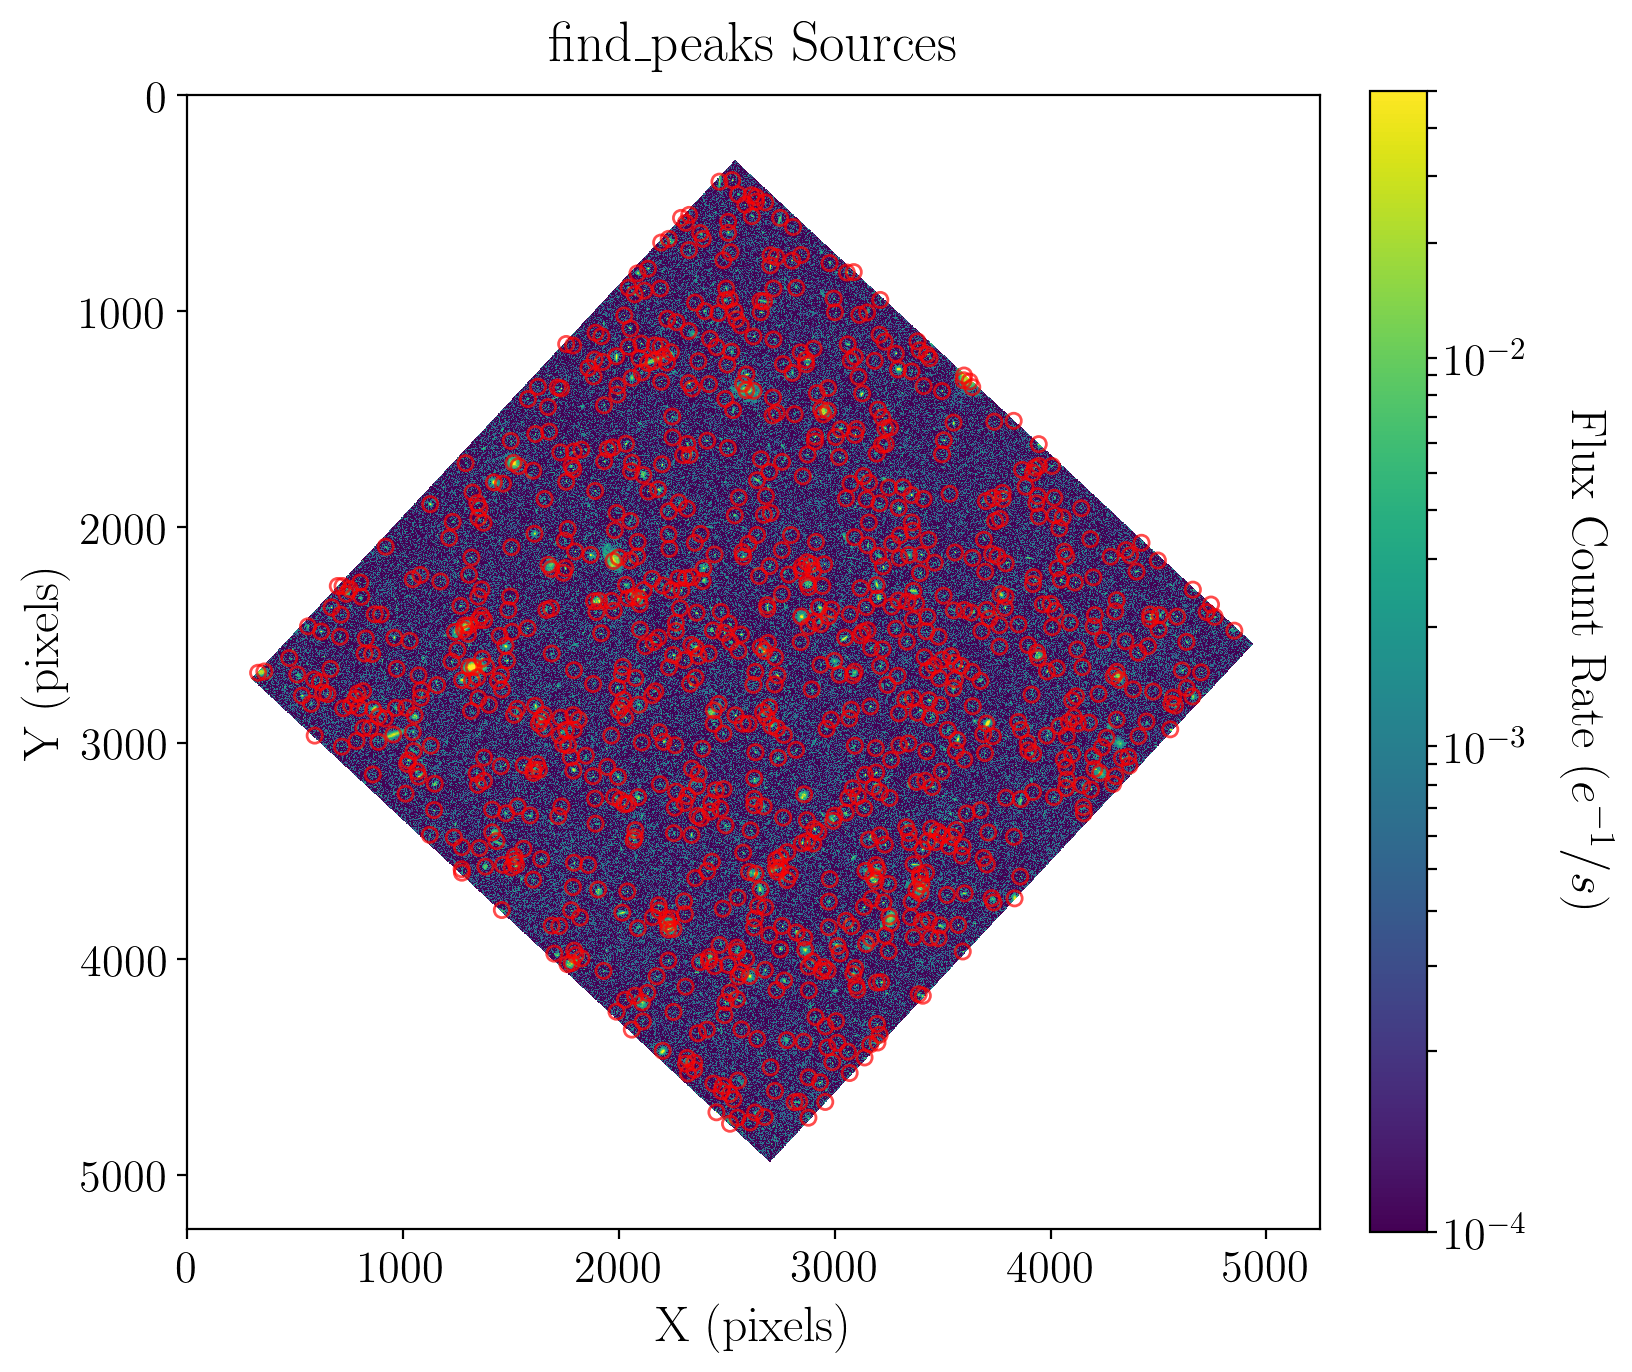

In [36]:
# Set up the figure with subplots
fig, ax1 = plt.subplots(1, 1, figsize=(8, 8))

# Plot the data
fitsplot = ax1.imshow(np.ma.masked_where(xdf_image.mask, xdf_image_clipped), norm=norm_image)
ax1.scatter(sources_findpeaks['x_peak'], sources_findpeaks['y_peak'], s=30, marker='o', 
            lw=1, alpha=0.7, facecolor='None', edgecolor='r')

# Define the colorbar
cbar = plt.colorbar(fitsplot, fraction=0.046, pad=0.04, ticks=LogLocator(subs=range(10)))
labels = ['$10^{-4}$'] + [''] * 8 + ['$10^{-3}$'] + [''] * 8 + ['$10^{-2}$']
cbar.ax.set_yticklabels(labels)

# Define labels
cbar.set_label(r'Flux Count Rate ($e^{-1}/s$)', rotation=270, labelpad=30)
ax1.set_xlabel('X (pixels)')
ax1.set_ylabel('Y (pixels)')
ax1.set_title('find\_peaks Sources')

plt.show()

---
## Image Segmentation

Beyond traditional source detection methods, an additional option for identifying sources in image data is a process called **image segmentation**. This method identifies and labels contiguous (connected) objects within an image. 

You might have noticed that, in the previous source detection algorithms, large and extended sources are often incorrectly identified as more than one source. Segmentation would label all the pixels within a large galaxy as belonging to the same object, and would allow the user to then measure the photometry, centroid, and morphology of the entire object at once.

#### Creating a `SegmentationImage`

In `photutils`, image segmentation maps are created using the threshold method in the `detect_sources()` function. This method identifies all of the objects in the data that have signals above a determined **`threshold`** (usually defined as a multiple of the standard deviation) and that have more than a defined number of adjoining pixels, **`npixels`**. The data can also optionally be smoothed using a kernel, **`filter_kernel`**, before applying the threshold cut.

The `detect_sources()` function returns a `SegmentationImage` object: an array in which each object is labeled with an integer. As a simple example, a segmentation map containing two distinct sources might look like this:

```
0 0 0 0 0 0 0 0 0 0
0 1 1 0 0 0 0 0 0 0
1 1 1 1 1 0 0 0 2 0
1 1 1 1 0 0 0 2 2 2
1 1 1 0 0 0 2 2 2 2
1 1 1 1 0 0 0 2 2 0
1 1 0 0 0 0 2 2 0 0
0 1 0 0 0 0 2 0 0 0
0 0 0 0 0 0 0 0 0 0
```
where all of the pixels labeled `1` belong to the first source, all those labeled `2` belong to the second, and all null pixels are designated to be background.

Let's see what the segmentation map for our XDF data will look like.

In [9]:
from photutils import detect_sources
from photutils.utils import random_cmap

In [47]:
# Define threshold and minimum object size
threshold = 5. * std
npixels = 15

# Create a segmentation image
segm = detect_sources(xdf_image.data, threshold, npixels)

print('Found {} sources'.format(segm.max))

Found 1191 sources


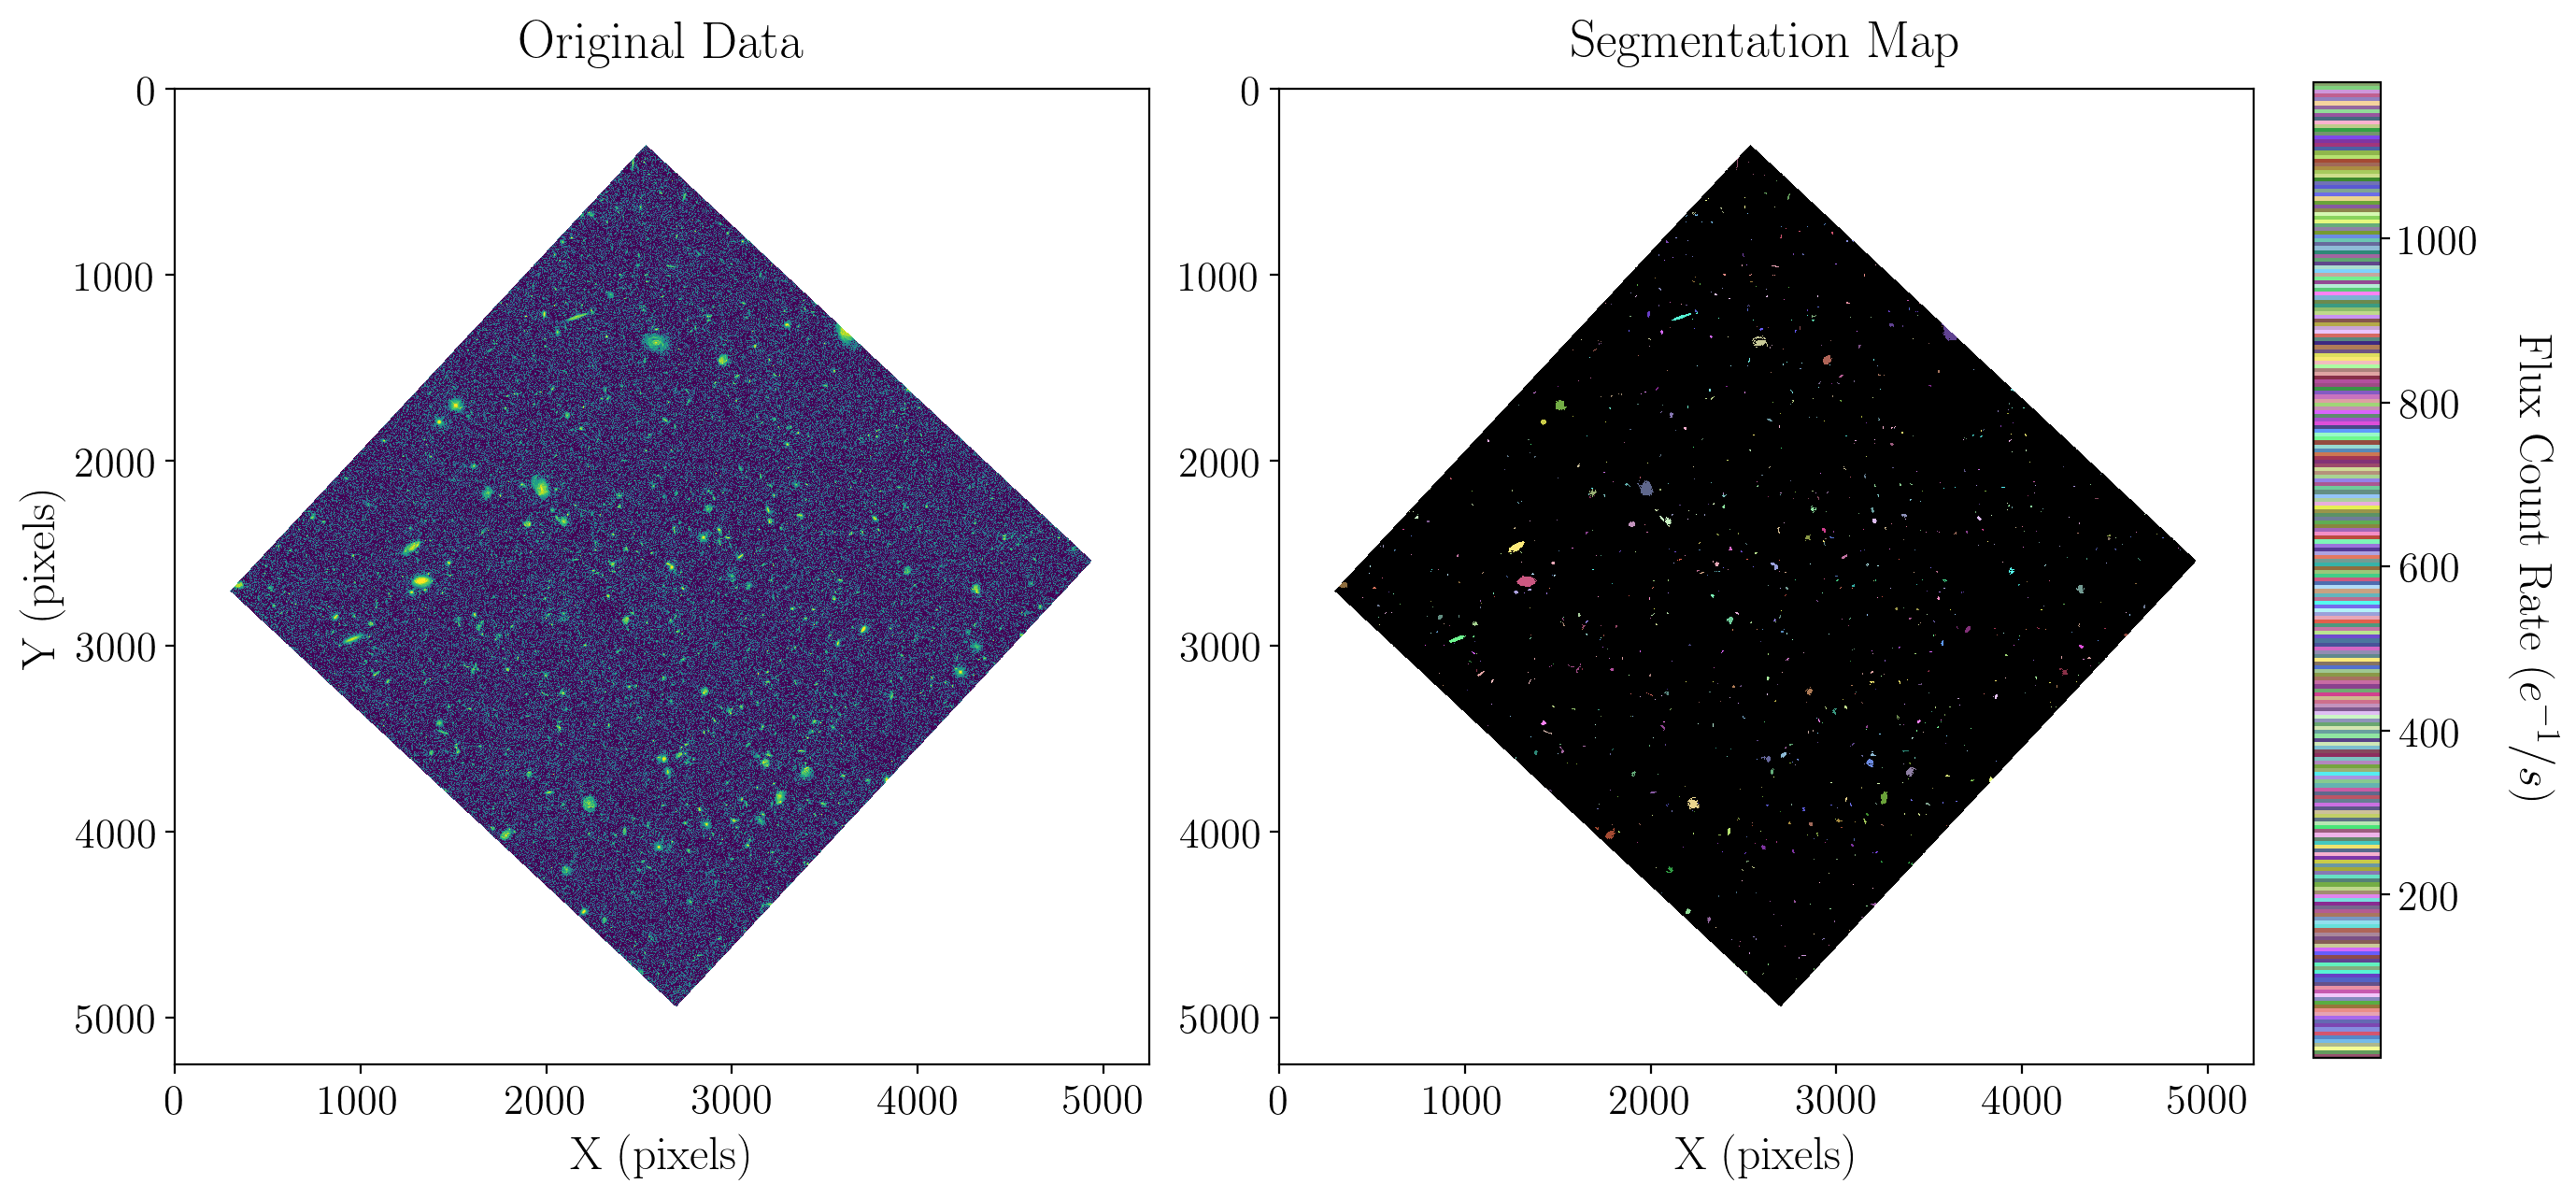

In [48]:
# Set up the figure with subplots
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(12, 6))
plt.tight_layout()

# Plot the original data
fitsplot = ax1.imshow(np.ma.masked_where(xdf_image.mask, xdf_image_clipped), norm=norm_image)
ax1.set_xlabel('X (pixels)')
ax1.set_ylabel('Y (pixels)')
ax1.set_title('Original Data')

# Plot the segmentation image
rand_cmap = random_cmap(random_state=12345)
rand_cmap.set_under('black')
segplot = ax2.imshow(np.ma.masked_where(xdf_image.mask, segm), vmin=1, cmap=rand_cmap)
ax2.set_xlabel('X (pixels)')
ax2.set_title('Segmentation Map')

# Define the colorbar
cbar_ax = fig.add_axes([1, 0.09, 0.03, 0.87])
cbar = plt.colorbar(segplot, cbar_ax)
cbar.set_label(r'Flux Count Rate ($e^{-1}/s$)', rotation=270, labelpad=30)

plt.show()

Compare the sources in original data to those in the segmentation image. Each color in the segmentation map denotes a separate source.

You can easily see that larger galaxies are shown in the segmentation map as contiguous objects of the same color - for example, the two yellow and pink galaxies near (1500, 2500). Each pixel containing light from the same galaxy has been labeled as belonging to the same object.

<div class="alert alert-block alert-info">
<h3>**Exercises:**</h3><br>
Recompute the `SegmentationImage`, but alter the threshold and the minimum number of pixels in a source. How does changing the threshold affect the results? What about changing the number of pixels?
</div>

#### Analyzing `source_properties`

Once we have a `SegmentationImage` object, `photutils` provides many powerful tools to manipulate and analyze the identified objects. 

Individual objects within the segmentation map can be altered using methods such as `relabel` to change the labels of objects, `remove_labels` to remove objects, or `deblend_sources` to separating overlapping sources that were incorrectly labeled as one source.

However, perhaps the most powerful aspect of the `SegmentationImage` is the ability to create a catalog using `source_properties` to measure the centroids, photometry, and morphology of the detected objects:

In [34]:
from photutils import source_properties

In [49]:
catalog = source_properties(xdf_image.data, segm)
table = catalog.to_table()
print(table)
print(table.colnames)

 id      xcentroid      ...         cxy                  cyy         
            pix         ...       1 / pix2             1 / pix2      
---- ------------------ ... -------------------- --------------------
   1 2465.6563851369983 ...  0.06586117853274677 0.007718700495270243
   2 2525.7146682862567 ...  -0.4550949855071517   0.7234921982823534
   3 2552.2117255592093 ...  -0.2532160317243995   0.6564821929840179
   4   2613.63719128523 ...   0.0830362050293753   0.8983772637003175
   5  2634.674993705567 ...  0.19169454941634784   1.5831018426475838
   6 2678.1091188199425 ...  -1.1539569187642806   1.0029644256476158
   7 2585.6085374714853 ...  0.22735601208579106   1.2150447289121327
   8 2616.0955067306063 ...  -0.3080147577844529    0.369822234483922
   9 2743.1885611302587 ...  0.09697072664950096  0.02799777839477976
  10 2289.1810436855694 ...   1.0625618996024824   1.6310668301378817
 ...                ... ...                  ...                  ...
1182 2452.0729469668

#### Creating apertures from segmentation data

We can use this information to create isophotal ellipses for each identified source. These ellipses can also later be used as photometric apertures!

In [39]:
from photutils import EllipticalAperture

In [50]:
# Define the approximate isophotal extent
r = 4.

# Create the apertures
apertures = []
for obj in catalog:
    position = (obj.xcentroid.value, obj.ycentroid.value)
    a = obj.semimajor_axis_sigma.value * r
    b = obj.semiminor_axis_sigma.value * r
    theta = obj.orientation.value
    apertures.append(EllipticalAperture(position, a, b, theta=theta))

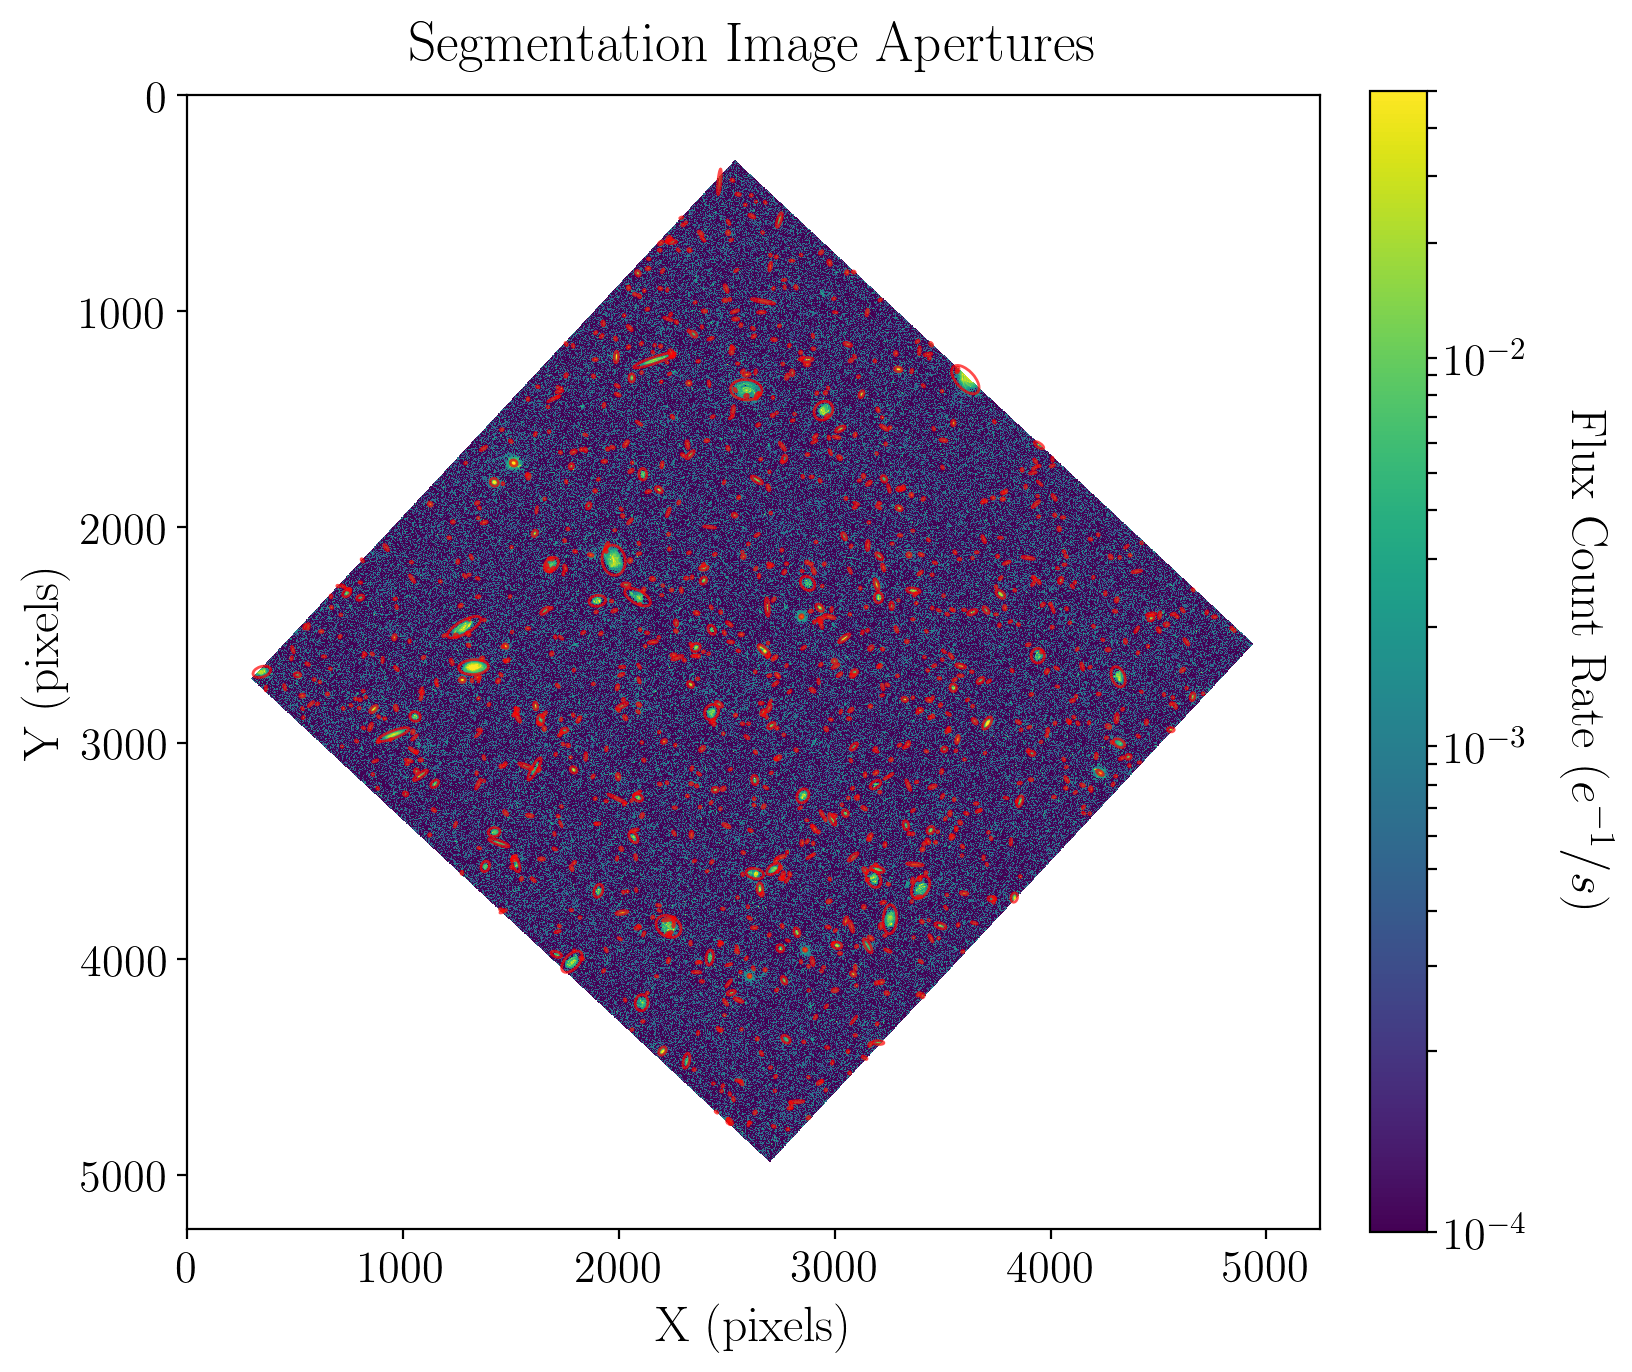

In [51]:
# Set up the figure with subplots
fig, ax1 = plt.subplots(1, 1, figsize=(8, 8))

# Plot the data
fitsplot = ax1.imshow(np.ma.masked_where(xdf_image.mask, xdf_image_clipped), norm=norm_image)

# Plot the apertures
for aperture in apertures:
    aperture.plot(color='red', lw=1, alpha=0.7, ax=ax1)

# Define the colorbar
cbar = plt.colorbar(fitsplot, fraction=0.046, pad=0.04, ticks=LogLocator(subs=range(10)))
labels = ['$10^{-4}$'] + [''] * 8 + ['$10^{-3}$'] + [''] * 8 + ['$10^{-2}$']
cbar.ax.set_yticklabels(labels)

# Define labels
cbar.set_label(r'Flux Count Rate ($e^{-1}/s$)', rotation=270, labelpad=30)
ax1.set_xlabel('X (pixels)')
ax1.set_ylabel('Y (pixels)')
ax1.set_title('Segmentation Image Apertures')

plt.show()

<div class="alert alert-block alert-info">
<h3>**Exercises:**</h3><br>
Play with the isophotal extent of the elliptical apertures (defined above as `r`). Observe how changing this value affects the apertures that are created.
</div>

It is clear that using `photutils` for image segmentation can allow users to generate highly customized apertures - great for complex data that contain many different kinds of celestial sources.

## Conclusions

The `photutils` package provides users with a variety of methods for detecting sources in their data, from familar algorithms such as `DAOFind` and `starfind`, to more complex and customizable image segmentation algorithms. These methods allow for easy creation of a diverse array of apertures that can be used for photometric analysis.


##### To continue with this `photutils` tutorial, go on to the [aperture photometry](03_photutils_aperture_photometry.ipynb) or [PSF photometry notebook](04_photutils_psf_photometry.ipynb).

---
<i>July 2018

Author: Lauren Chambers (lchambers@stsci.edu)

For more examples and details, please visit the [photutils](http://photutils.readthedocs.io/en/stable/index.html) documentation.</i>